In [1]:
import ee
import datetime
import os
import itertools
import sys

from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [2]:
ee.Initialize()

In [3]:
# append upper folder into sys-path during run time so we can
# import our own moduls
sys.path.append('../Process_1_GEE_Python_Classification/')

# import the temporal_consistency_check class
from BackGround_modules.Class_5_Temporal_consistency_check import Temporal_consistency_check

In [4]:
# define basic parameters
year_range = [f'{i}_{i+2}' for i in range(1990,2020,3)]

len_landsat_1990_2013 = 8
len_sentinel_2014_2019 = 2

In [5]:
year_range

['1990_1992',
 '1993_1995',
 '1996_1998',
 '1999_2001',
 '2002_2004',
 '2005_2007',
 '2008_2010',
 '2011_2013',
 '2014_2016',
 '2017_2019']

### Import Classified_random_img and Check_sample

In [6]:
# Define the threshold for sum_img of 10 classifications
Threshold_sum_classificatioin = 4

# import the classified imgs
Classified_img_1990_2013  = [ee.ImageCollection(f"users/wangjinzhulala/North_China_Plain_Python/classification_img/Spectrum_Normalize_Fourier_Terrain_Meterology_{year}")
                               .sum().gt(Threshold_sum_classificatioin).set('name',year)   for year in year_range[:-2]]

Classified_img_2014_2019  = [ee.ImageCollection(f"users/wangjinzhulala/North_China_Plain_Python/classification_img/Spectrum_Normalize_Fourier_Terrain_Meterology_{year}")
                               .sum().gt(Threshold_sum_classificatioin).set('name',year)   for year in year_range[-2:]]

In [7]:
# because the window-size of the teomporal check is 3, which mean the last
# 2 classifications can not be checked, so we sum up the last 2 classificaitons
# and choose the maxmum (2) value as the built-up pixel of 2014-2016; 

Classified_img_2014_2016 = ee.ImageCollection(Classified_img_2014_2019).sum().eq(2).set('name','2014_2016')
Classified_img_2017_2019 = Classified_img_2014_2019[1]


# put all classified image together
Classified_imgs = Classified_img_1990_2013 + [Classified_img_2014_2016,Classified_img_2017_2019]

In [8]:
# import the untouched control points, which are diveded by a random column with a 101 random state
Sample_Landsat  = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Sample_Points/Control_points")\
                    .randomColumn('split', 101)\
                    .filterMetadata('split','less_than',0.25)

Sample_Sentinel = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Sample_Points/Sentinel_2017_2019")\
                    .randomColumn('split', 101)\
                    .filterMetadata('split','less_than',0.25)

### Perform temporal consistency check

In [9]:
# get the checked results
Iteration_num = 10
Window_size = [2,3,4,5,6]
modes = ['only_forward'] #['backward_forward','forward_backward','only_forward','only_backward']

Check_df_list = []

for window in Window_size:
    for mode in modes:
    
        # get the checked classification imgs, here they are stored in a dictionary
        Iter_temporal_check_instaces = Temporal_consistency_check(Classified_imgs,window,Iteration_num)\
                                        .Iterate_the_check(mode = mode)

        # convert the Iter_temporal_check_instaces to a Dataframe
        Check_instances = pd.DataFrame(Iter_temporal_check_instaces).T
        Check_instances.columns = year_range

        # Add the window-size and iteration-num to the df
        Check_instances['Mode'] = [mode] * Iteration_num
        Check_instances['Window'] = [window] * Iteration_num
        Check_instances['Iteration'] = range(1,Iteration_num+1)

        # Reorder the columns
        cols = Check_instances.columns
        Check_instances = Check_instances[list(cols[-3:]) + list(cols[:-3])] 

        # add the checked df into list
        Check_df_list.append(Check_instances)

================  Check Report  ================
Check length is    ---> 2
Check weights are  ---> [2, 1]
Check threshold is ---> 3
Check iteration is ---> 10
================  Check Report  ================
Check length is    ---> 3
Check weights are  ---> [3, 1, 1]
Check threshold is ---> 4
Check iteration is ---> 10
================  Check Report  ================
Check length is    ---> 4
Check weights are  ---> [4, 1, 1, 1]
Check threshold is ---> 6
Check iteration is ---> 10
================  Check Report  ================
Check length is    ---> 5
Check weights are  ---> [5, 1, 1, 1, 1]
Check threshold is ---> 7
Check iteration is ---> 10
================  Check Report  ================
Check length is    ---> 6
Check weights are  ---> [6, 1, 1, 1, 1, 1]
Check threshold is ---> 9
Check iteration is ---> 10


In [10]:
# merge all instace_df together
Check_df = pd.concat(Check_df_list)
Check_df.reset_index(inplace=True,drop=True)

### Assess the accuracy after the temporal check

##### Transform the Check_sample into long format so each row is an observation with spicific window-iteration-year condition

In [11]:
# create sample list for accuracy assesment
Check_sample = [Sample_Landsat] * len_landsat_1990_2013 + \
               [Sample_Sentinel] * len_sentinel_2014_2019

Sample_size = [Sample_Landsat.size().getInfo()]  * len_landsat_1990_2013 + \
              [Sample_Sentinel.size().getInfo()] * len_sentinel_2014_2019

In [12]:
# attach Check_sample to the Check_instaces_long 
Check_instaces_long = pd.DataFrame(Check_df.set_index(['Mode','Window','Iteration']).stack()).reset_index()
Check_instaces_long.columns = ['Mode','Window','Iteration','year','Image']

In [14]:
# add check_sample and sample_size for later accuracy assessment
Check_instaces_long['Check_sample'] = Check_sample * ( len(modes) * len(Window_size) * (Iteration_num) )
Check_instaces_long['Sample_size']  = Sample_size *  ( len(modes) * len(Window_size) * (Iteration_num) )

# extract checked_img pixel value to sample
Check_instaces_long['Sample_extract_img_value'] = Check_instaces_long.apply(lambda x: ee.Image(x['Image'])\
                                                                                         .sampleRegions(collection = x['Check_sample'], 
                                                                                                        properties = ['Built'], 
                                                                                                        scale      = 30,
                                                                                                        tileScale  = 4),1)
# if the 'Built' attribute equals to the 'classification', then its a corrected classified point
Check_instaces_long['Correct_num'] = Check_instaces_long.apply(lambda x: ee.FeatureCollection(x['Sample_extract_img_value'])\
                                                                        .filter(ee.Filter.equals('Built',None,'classification'))\
                                                                        .size(),1)


In [15]:
Check_instaces_long

,Mode,Window,Iteration,year,Image,Check_sample,Sample_size,Sample_extract_img_value,Correct_num
0,only_forward,2,1,1990_1992,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,"ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Number({\n ""type"": ""Invocation"",\n ""argum..."
1,only_forward,2,1,1993_1995,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,"ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Number({\n ""type"": ""Invocation"",\n ""argum..."
2,only_forward,2,1,1996_1998,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,"ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Number({\n ""type"": ""Invocation"",\n ""argum..."
3,only_forward,2,1,1999_2001,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,"ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Number({\n ""type"": ""Invocation"",\n ""argum..."
4,only_forward,2,1,2002_2004,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,"ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Number({\n ""type"": ""Invocation"",\n ""argum..."
...,...,...,...,...,...,...,...,...,...
495,only_forward,6,10,2005_2007,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,"ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Number({\n ""type"": ""Invocation"",\n ""argum..."
496,only_forward,6,10,2008_2010,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,"ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Number({\n ""type"": ""Invocation"",\n ""argum..."
497,only_forward,6,10,2011_2013,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,"ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Number({\n ""type"": ""Invocation"",\n ""argum..."
498,only_forward,6,10,2014_2016,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",2017,"ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Number({\n ""type"": ""Invocation"",\n ""argum..."


##### Calculate the accuracy in Python, which will take a long time

In [ ]:
chunk_size = 10
correct_num_list = []

unsuccess_idx = []

# chop the featurecollection into several sub-list, so we can apply map function
# to decrease the computation time
for i in range(0,len(Check_instaces_long),chunk_size):
    
    # subset from the Check_instaces_long df
    sub_df = Check_instaces_long.iloc[i:i+chunk_size]
    
    # get attributes
    md = sub_df['Mode'].values
    wd = sub_df['Window'].values
    it = sub_df['Iteration'].values
    yr = sub_df['year'].values
    sz = sub_df['Sample_size'].values

    # covert the fe_col into a ee.List
    sample_ext_img = list(sub_df['Sample_extract_img_value'].values)
    sample_ext_img_list = ee.List(sample_ext_img)

    # get the value
    correct_num =  sample_ext_img_list.map(lambda x: ee.FeatureCollection(x)\
                                                        .filter(ee.Filter.equals('Built',None,'classification')).size())\
                                                        .getInfo()

    # storge the attribute into a df
    tmp_df = pd.DataFrame([md,wd,it,yr,sz,correct_num],index=['Mode','Window','Iteration',
                                                               'year','Size','Correct_num']).T

    # add the correct_num to list
    correct_num_list.append(tmp_df)

    # print out the process
    print(f'{i+chunk_size}/{len(Check_instaces_long)} finished!')

10/500 finished!
20/500 finished!
30/500 finished!


##### Compute the accuracy after temporal-check

In [18]:
# # Calculate the checked accuracy
# Checked_acc = pd.concat(correct_num_list)
# Checked_acc['Accuracy'] = Checked_acc['Correct_num']/Checked_acc['Size']*100

# # Save the accuracy to disk
# Checked_acc.to_csv('./Result/Temporal_check_acc.csv',index=False)

# load the acc_df
Checked_acc = pd.read_csv('./Result/Temporal_check_acc.csv')

# concert these columns into category, so we can make figures
Checked_acc['Iteration'] = Checked_acc['Iteration'].astype('category')
Checked_acc['year'] = Checked_acc['year'].astype('category')

In [19]:
Checked_acc

,Mode,Window,Iteration,year,Size,Correct_num,Accuracy
0,only_forward,2,1,1990_1992,1980,1938,97.878788
1,only_forward,2,1,1993_1995,1980,1930,97.474747
2,only_forward,2,1,1996_1998,1980,1929,97.424242
3,only_forward,2,1,1999_2001,1980,1935,97.727273
4,only_forward,2,1,2002_2004,1980,1938,97.878788
...,...,...,...,...,...,...,...
495,only_forward,6,10,2005_2007,1980,1937,97.828283
496,only_forward,6,10,2008_2010,1980,1919,96.919192
497,only_forward,6,10,2011_2013,1980,1929,97.424242
498,only_forward,6,10,2014_2016,2017,1954,96.876549


##### Observe that window-size of 3 is the optimun size, because the bigger the window size, the more imgs wouldn't be temporal corrected. So we choose 3 as window size even though 5 look like the best one

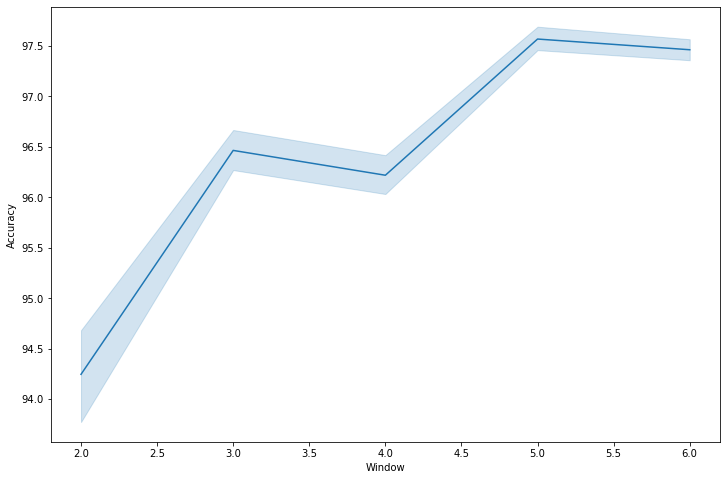

In [20]:
plt.figure(figsize=(12,8))
sns.lineplot(data = Checked_acc,x='Window',y='Accuracy')

##### Observe that  9 iterations  achieved a stable accuracy. here we neglect the seemingly high accuracy at lower iterations because we care more about stable performance, which is the key of temporal correction

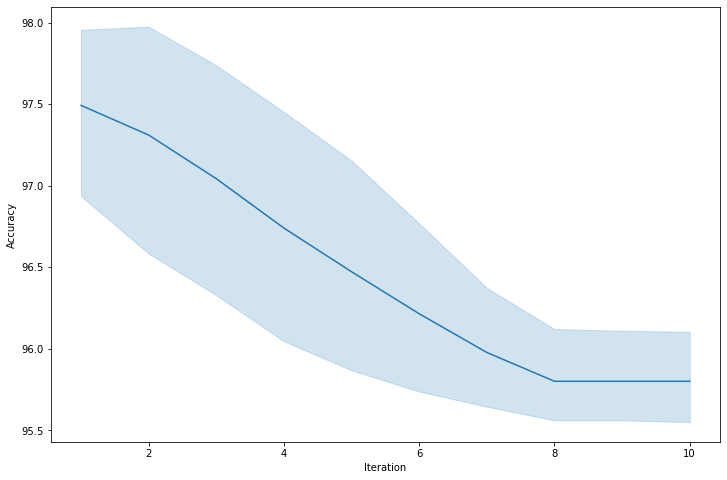

In [21]:
plt.figure(figsize=(12,8))
sns.lineplot(data = Checked_acc[Checked_acc['Window'] == 3],
             x='Iteration',
             y='Accuracy')

##### Create the Mosaic image from all temporal-checked imgs

In [16]:
# get the temporal_checked imgs
Temporal_checked_select  = Check_instaces_long[(Check_instaces_long['Iteration'] == 9)&\
                                              (Check_instaces_long['Window']    == 3)]['Image'].values

# reclassify the classification img
Temporal_checked_select_re = [(i,img)[1].remap([0,1],[0,10-(i,img)[0]]) for i,img in enumerate(Temporal_checked_select)]

# mosaic all checked imgs together
Classification_Mosaic = ee.ImageCollection(Temporal_checked_select_re).max()

Export each year's classification img of temporal_checked

In [29]:
# here we find that temporcal checked img with 
# "Mode=forward_backward", "Iteration=5", "Window=3"
# are the best quality imgs

Target_temporal_checked = Check_instaces_long[(Check_instaces_long['Mode']      == 'only_forward')&\
                                              (Check_instaces_long['Iteration'] == 9)&\
                                              (Check_instaces_long['Window']    == 3)]

In [30]:
# export all temporal checked imgs
for idx,row in Target_temporal_checked.iterrows():
    
    Mode      = row[0]
    Window    = row[1]
    Iteration = row[2]
    year      = row[3]
    img       = row[4]
    
    # determine the img name
    export_name = f'{Mode}_Window_{Window}_It_{Iteration}_{year}'
    
    task = ee.batch.Export.image.toCloudStorage(image = img,
                                                description=export_name,
                                                bucket='north_china_plain',
                                                fileNamePrefix=export_name,
                                                region=North_China_Plain.geometry().bounds(),
                                                scale=30,
                                                maxPixels=int(1e13),
                                                skipEmptyTiles=True) 
    
    task.start()
    
    print(f'Exporting {export_name} successful!')

Exporting only_forward_Window_3_It_9_1990_1992 successful!
Exporting only_forward_Window_3_It_9_1993_1995 successful!
Exporting only_forward_Window_3_It_9_1996_1998 successful!
Exporting only_forward_Window_3_It_9_1999_2001 successful!
Exporting only_forward_Window_3_It_9_2002_2004 successful!
Exporting only_forward_Window_3_It_9_2005_2007 successful!
Exporting only_forward_Window_3_It_9_2008_2010 successful!
Exporting only_forward_Window_3_It_9_2011_2013 successful!
Exporting only_forward_Window_3_It_9_2014_2016 successful!
Exporting only_forward_Window_3_It_9_2017_2019 successful!


Export the mosaiced classification img 

In [17]:
# import the export region
North_China_Plain = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

# Export the result
export_name = 'Mosaic_only_forward'

task = ee.batch.Export.image.toCloudStorage(image = Classification_Mosaic,
                                            description=export_name,
                                            bucket='north_china_plain',
                                            fileNamePrefix=export_name,
                                            region=North_China_Plain.geometry().bounds(),
                                            scale=30,
                                            maxPixels=int(1e13),
                                            skipEmptyTiles=True) 

task.start()
    

##### Observe that the temporal correction have incresed the classification accuracy

1) import the original accuracy df

In [22]:
# access the original acc_df
Sentinel_Acc = pd.read_csv('../Process_1_GEE_Python_Classification/Sub_Process_7_Classification_on_img/Result/Classification_Accuracy_landsat_sentinel.csv')
Landsat_Acc  = pd.read_csv('../Process_1_GEE_Python_Classification/Sub_Process_7_Classification_on_img/Result/Classification_Accuracy.csv')

In [23]:
# Define the classification only use landsat as input
landsat_col = ['Landsat_1990_1992', 'Landsat_1993_1995', 'Landsat_1996_1998','Landsat_1999_2001',
               'Landsat_2002_2004', 'Landsat_2005_2007','Landsat_2008_2010', 'Landsat_2011_2013']

# concatenate all accuracy into one df
Original_landsat = Landsat_Acc[Landsat_Acc['year'].isin(landsat_col)]
Original_acc = pd.concat([Original_landsat,Sentinel_Acc])

In [24]:
# formeting the original addcuracy_df
Original_acc['Year'] = Original_acc['year'].apply(lambda x: x[-9:])
Original_acc

,year,seed,Overall_ACC,Precisioin_non_built,Precisioin_built,Recall_non_built,Recall_built,Year
0,Landsat_1990_1992,0,94.10,93.90,94.30,94.51,93.67,1990_1992
1,Landsat_1990_1992,1,94.20,93.75,94.68,95.06,93.28,1990_1992
2,Landsat_1990_1992,2,95.18,94.37,96.03,96.14,94.22,1990_1992
3,Landsat_1990_1992,3,94.53,93.90,95.18,95.28,93.78,1990_1992
4,Landsat_1990_1992,4,94.89,94.31,95.50,95.70,94.06,1990_1992
...,...,...,...,...,...,...,...,...
15,Sentinel_2017_2019,5,94.83,95.91,93.72,93.99,95.72,2017_2019
16,Sentinel_2017_2019,6,94.03,93.19,94.88,94.83,93.25,2017_2019
17,Sentinel_2017_2019,7,93.61,92.87,94.34,94.13,93.12,2017_2019
18,Sentinel_2017_2019,8,94.26,94.67,93.85,93.96,94.57,2017_2019


2) make a figure to compare all the accuracy 

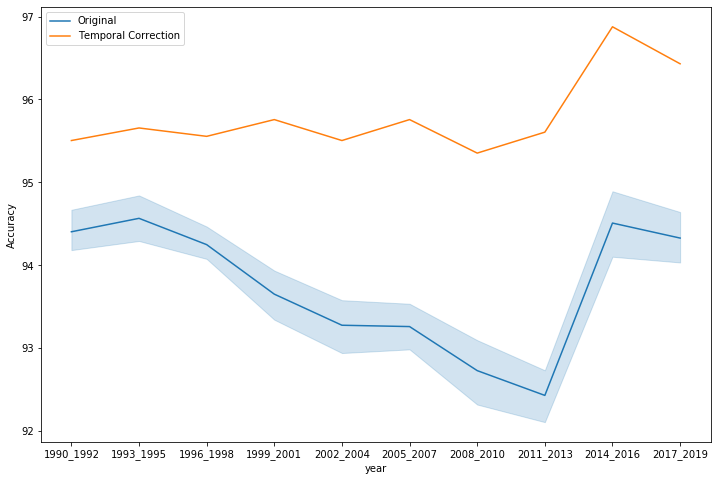

In [26]:
plt.figure(figsize=(12,8))

# original accuracy
sns.lineplot(data = Original_acc,x = 'Year',y='Overall_ACC',label = 'Original')

# temporal correction
sns.lineplot(data = Checked_acc[((Checked_acc['Window']==3)&
                                 (Checked_acc['Iteration']==9))],
             x='year',
             y='Accuracy',
            label = 'Temporal Correction')

##### Add the checked img to the map

In [27]:
# Color_ramp for Mosaic img
Mosaic_VIS = {'min':0,
              'max':10,
              "palette":["000000","3288bd","66c2a5","abdda4",
                         "e6f598","ffffbf","fee08b","fdae61",
                         "f46d43","d53e4f","9e0142"]}

In [28]:
Map = geemap.Map()
Map.setCenter(115.4508, 35.2492,10)


# define filter parameters
mode = 'only_forward' # 'backward_forward' |'forward_backward'|'only_forward'|'only_backward'
window_len = 3
year_idx = '1999_2001'

# get the original classification for later comparision
Original = ee.ImageCollection(Classified_imgs).filterMetadata('name','equals',year_idx)

# get the temporal checked imgs
Temporal_checkd = Check_instaces_long[(Check_instaces_long['Mode']   == mode)&
                                      (Check_instaces_long['Window'] == window_len)&
                                      (Check_instaces_long['year']   == year_idx)]

# get the checked img with different iteration
img_year_window_filtered = [Temporal_checkd[Temporal_checkd['Iteration'] == i]['Image'].values[0] 
                            for i in range(1,Iteration_num + 1)]


# add the img to map
Map.add_basemap('HYBRID')

Map.addLayer(Original,                    {'min':0,'max':1},'Original')

Map.addLayer(img_year_window_filtered[0], {'min':0,'max':1},'Iter_1')
Map.addLayer(img_year_window_filtered[2], {'min':0,'max':1},'Iter_3')
Map.addLayer(img_year_window_filtered[4], {'min':0,'max':1},'Iter_5')
Map.addLayer(img_year_window_filtered[6], {'min':0,'max':1},'Iter_7')
Map.addLayer(img_year_window_filtered[8], {'min':0,'max':1},'Iter_9')
Map.addLayer(img_year_window_filtered[9], {'min':0,'max':1},'Iter_10')

Map.addLayer(Classification_Mosaic, Mosaic_VIS,'Mosaic')

Map

Map(center=[35.2492, 115.4508], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButt…